MIT License

Copyright (c) 2024 Saurabh Shivpuje

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Simulation of Excitation Dynamics in the FMO Complex

In this section, we demonstrate the **adaptive variational quantum dynamics (AVQD)** simulation of the **Fenna–Matthews–Olson (FMO) complex**, a well-known model in photosynthetic energy transfer. 

The example compares the stochastic Schrödinger-based adaptive VQE simulation implemented via `QMAD` with the exact open-system dynamics simulated using **QuTiP**. The resulting population transfer between excitonic states is analyzed and visualized.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from qflux.variational_methods.qmad.solver import solve_avq_trajectory
from qflux.variational_methods.qmad.effh import EffectiveHamiltonian
from qflux.variational_methods.qmad.ansatz import Ansatz

## Defining the FMO Hamiltonian and Dissipators

We begin by defining the Hamiltonian for a truncated **five-site subsystem** of the FMO complex, followed by the Lindblad dissipators corresponding to relaxation (`α`), dephasing (`β`), and trapping (`γ`) processes.

These parameters are chosen to represent a simplified physical model that captures the key population transfer characteristics observed experimentally.

In [2]:
H = [
    [0, 0, 0, 0, 0],
    [0, 0.0267, -0.0129, 0.000632, 0],
    [0, -0.0129, 0.0273, 0.00404, 0],
    [0, 0.000632, 0.00404, 0, 0],
    [0, 0, 0, 0, 0],
]
H_fmo = np.pad(H, ((0, 3), (0, 3)), mode='constant')

alpha, beta, gamma = 3e-3, 5e-7, 6.28e-3

# Define dissipative operators (Lindblad operators)
Llist_f = [(np.diag([0] * i + [np.sqrt(alpha)] + [0] * (4 - i))) for i in range(1, 4)]
Llist_f += [(np.array([[np.sqrt(beta) if i == 0 and j == k else 0 for j in range(5)] for i in range(5)])) for k in range(1, 4)]
L_temp = np.zeros((5, 5))
L_temp[4, 3] = np.sqrt(gamma)
Llist_f.append(L_temp)
Llist_f_padded = [np.pad(matrix, ((0, 3), (0, 3)), mode='constant') for matrix in Llist_f]

# Initial state (excitation localized on site 2)
u0_fmo = np.zeros(8, dtype=np.complex128)
u0_fmo[1] = 1

## Running Multiple Stochastic Trajectories

The evolution of the system is computed using the **stochastic Schrödinger equation (SSE)** approach. We run several trajectories in parallel using the Python `multiprocessing` module, allowing the results to be averaged to approximate the ensemble behavior described by the Lindblad master equation.

In [3]:
def run_trajectories(num_trajectory, H, ansatz, tf, dt):
    param_list = [(H, ansatz, tf, dt) for _ in range(num_trajectory)]
    with Pool() as pool:
        results = pool.starmap(solve_avq_trajectory, param_list)
    return results

## Defining the Effective Hamiltonian and Ansatz

Using the `QMAD` module, we now define the **effective Hamiltonian** that incorporates dissipative dynamics and construct an **adaptive ansatz** for the system’s quantum state. The `solve_avq_trajectory` function propagates each trajectory under these definitions.

In [4]:

if __name__ == "__main__":
    tf = 450   # Final simulation time (fs)
    dt = 5     # Time step (fs)
    num_trajectory = 400
    H = EffectiveHamiltonian([H_fmo], [Llist_f_padded])
    ansatz = Ansatz(u0_fmo, relrcut=1e-5, vectorized=False)
    results = run_trajectories(num_trajectory, H, ansatz, tf, dt)

## Computing Expectation Values for Observables

For each trajectory, we calculate the **expectation values** of population operators corresponding to each excitonic site. The final ensemble-averaged populations are obtained by averaging over all stochastic trajectories.

In [5]:
Mexp_f = [
    np.diag([0, 1, 0, 0, 0, 0, 0, 0]),
    np.diag([0, 0, 1, 0, 0, 0, 0, 0]),
    np.diag([0, 0, 0, 1, 0, 0, 0, 0]),
    np.diag([1, 0, 0, 0, 0, 0, 0, 0]),
    np.diag([0, 0, 0, 0, 1, 0, 0, 0])
]

average_expectation_values = []

for j in range(num_trajectory):
    for k, observable in enumerate(Mexp_f):
        expectation_values = []
        for psi in results[j].psi:
            psi_dagger = np.conjugate(psi).T
            rho = np.outer(psi, psi_dagger)
            expectation_values.append(np.trace(np.dot(rho, observable)).real)
        if len(average_expectation_values) <= k:
            average_expectation_values.append(np.array(expectation_values))
        else:
            average_expectation_values[k] += np.array(expectation_values)

results_t_converted = [t for t in results[0].t]
average_expectation_values = [ev / num_trajectory for ev in average_expectation_values]

## Visualizing the Ensemble-Averaged Populations

The following plot displays the average expectation values of each excitonic site over time, representing the ensemble behavior obtained from the stochastic trajectories.

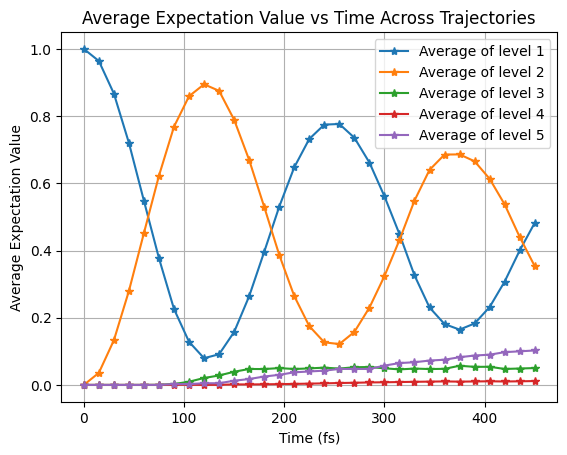

In [6]:
for k, avg_values in enumerate(average_expectation_values):
    plt.plot(results_t_converted[::3], avg_values[::3], '-*', label=f"Average of level {k+1}")
plt.xlabel('Time (fs)')
plt.ylabel('Average Expectation Value')
plt.title('Average Expectation Value vs Time Across Trajectories')
plt.legend()
plt.grid(True)
plt.show()

## Benchmarking with QuTiP Master Equation

To validate our stochastic-based AVQD results, we compute the **exact open-system dynamics** using the `mesolve` function from **QuTiP**. The simulation uses the same Hamiltonian, initial state, and dissipative operators as in the AVQD run.

In [7]:
from qutip import mesolve, Qobj
def qutip_prop(H, rho0, time_arr, c_ops, observable):
    result = mesolve(H, rho0, time_arr, c_ops, observable)
    return result.expect

### Defining the QuTiP Model

We redefine the Hamiltonian and collapse operators in QuTiP’s `Qobj` format, prepare the initial state, and compute populations at each site.

In [8]:
H = Qobj([
    [0, 0, 0, 0, 0],
    [0, 0.0267, -0.0129, 0.000632, 0],
    [0, -0.0129, 0.0273, 0.00404, 0],
    [0, 0.000632, 0.00404, 0, 0],
    [0, 0, 0, 0, 0],
])
alpha, beta, gamma = 3e-3, 5e-7, 6.28e-3
Llist_f = [Qobj(np.diag([0] * i + [np.sqrt(alpha)] + [0] * (4 - i))) for i in range(1, 4)]
Llist_f += [Qobj(np.array([[np.sqrt(beta) if i == 0 and j == k else 0 for j in range(5)] for i in range(5)])) for k in range(1, 4)]
L_temp = np.zeros((5, 5))
L_temp[4, 3] = np.sqrt(gamma)
Llist_f.append(Qobj(L_temp))
psi0_f = Qobj([[0], [1], [0], [0], [0]])
times = np.linspace(0.0, 450.0, 2000)
Mexp_f = [Qobj(np.diag([0, 1, 0, 0, 0])), Qobj(np.diag([0, 0, 1, 0, 0])), Qobj(np.diag([0, 0, 0, 1, 0])), Qobj(np.diag([1, 0, 0, 0, 0])), Qobj(np.diag([0, 0, 0, 0, 1]))]
population = qutip_prop(H, psi0_f, times, Llist_f, Mexp_f)

/Users/souda/myGitHub/qflux/.venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


## Comparing QuTiP and AVQD Results

Finally, we overlay the **exact QuTiP populations** with the **ensemble-averaged AVQD (SSE) results**, showing strong agreement between the two methods. This confirms that the adaptive variational framework accurately reproduces dissipative dynamics for the FMO complex.

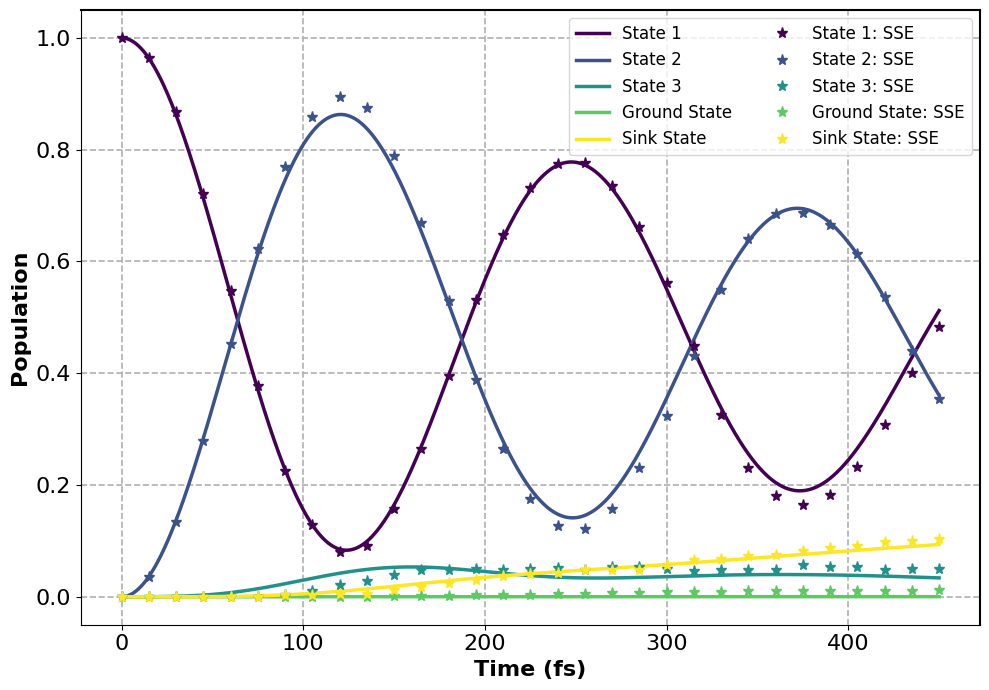

In [ ]:
plt.figure(figsize=(10, 7))
line_width, marker_size = 2.5, 8
labels = ["State 1", "State 2", "State 3", "Ground State", "Sink State"]
colors = plt.cm.viridis(np.linspace(0, 1, len(population)))
for i, (expec, label) in enumerate(zip(population, labels)):
    plt.plot(times, expec, label=label, color=colors[i], linewidth=line_width)
for k, avg_values in enumerate(average_expectation_values):
    plt.plot(results_t_converted[::3], avg_values[::3], '*', color=colors[k], markersize=marker_size, label=f'{labels[k]}: SSE')
plt.xlabel('Time (fs)', fontsize=16, fontweight='bold')
plt.ylabel('Population', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=12, loc='upper right', ncol=2, bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', linewidth=1.2)
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.tight_layout()
#plt.savefig("state_populations_horizontal_legend.png", dpi=300)
plt.show()